# 04. Pytorch Custom Datasets

If you have any vision data, ook at torchvision
if you have any text data, llook at torchtext
if you hjave any audio, use Torchaudio
for recomendations, use torchrec
these are domain libraries

## What is a custom dataset?

A **custom dataset** is a collection of data relating to a specific problem you're working on.

In essence, a **custom dataset** can be comprised of almost anything.

For example, if we were building a food image classification app like [Nutrify](https://nutrify.app), our custom dataset might be images of food.

Or if we were trying to build a model to classify whether or not a text-based review on a website was positive or negative, our custom dataset might be examples of existing customer reviews and their ratings.

Or if we were trying to build a sound classification app, our custom dataset might be sound samples alongside their sample labels.

Or if we were trying to build a recommendation system for customers purchasing things on our website, our custom dataset might be examples of products other people have bought.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-domain-libraries.png" alt="different pytorch domain libraries can be used for specific PyTorch problems" width=1000/>

*PyTorch includes many existing functions to load in various custom datasets in the [`TorchVision`](https://pytorch.org/vision/stable/index.html), [`TorchText`](https://pytorch.org/text/stable/index.html), [`TorchAudio`](https://pytorch.org/audio/stable/index.html) and [`TorchRec`](https://pytorch.org/torchrec/) domain libraries.*

But sometimes these existing functions may not be enough.

In that case, we can always subclass `torch.utils.data.Dataset` and customize it to our liking.

## What we're going to cover

We're going to be applying the PyTorch Workflow we covered in [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/) and [notebook 02](https://www.learnpytorch.io/02_pytorch_classification/) to a computer vision problem.

But instead of using an in-built PyTorch dataset, we're going to be using our own dataset of pizza, steak and sushi images.

The goal will be to load these images and then build a model to train and predict on them.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-food-vision-layout.png" alt="building a pipeline to load in food images and then building a pytorch model to classify those food images" width=800 />

*What we're going to build. We'll use `torchvision.datasets` as well as our own custom `Dataset` class to load in images of food and then we'll build a PyTorch computer vision model to hopefully be able to classify them.*

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **0. Importing PyTorch and setting up device-agnostic code** | Let's get PyTorch loaded and then follow best practice to setup our code to be device-agnostic.  |
| **1. Get data** | We're going to be using our own **custom dataset** of pizza, steak and sushi images. |
| **2. Become one with the data (data preparation)** | At the beginning of any new machine learning problem, it's paramount to understand the data you're working with. Here we'll take some steps to figure out what data we have. |
| **3. Transforming data** |Often, the data you get won't be 100% ready to use with a machine learning model, here we'll look at some steps we can take to *transform* our images so they're ready to be used with a model. |
| **4. Loading data with `ImageFolder` (option 1)** | PyTorch has many in-built data loading functions for common types of data. `ImageFolder` is helpful if our images are in standard image classification format. |
| **5. Loading image data with a custom `Dataset`** | What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of `torch.utils.data.Dataset`. |
| **6. Other forms of transforms (data augmentation)** | Data augmentation is a common technique for expanding the diversity of your training data. Here we'll explore some of `torchvision`'s in-built data augmentation functions. |
| **7. Model 0: TinyVGG without data augmentation** | By this stage, we'll have our data ready, let's build a model capable of fitting it. We'll also create some training and testing functions for training and evaluating our model. |
| **8. Exploring loss curves** | Loss curves are a great way to see how your model is training/improving over time. They're also a good way to see if your model is **underfitting** or **overfitting**. |
| **9. Model 1: TinyVGG with data augmentation** | By now, we've tried a model *without*, how about we try one *with* data augmentation? |
| **10. Compare model results** | Let's compare our different models' loss curves and see which performed better and discuss some options for improving performance. |
| **11. Making a prediction on a custom image** | Our model is trained to on a dataset of pizza, steak and sushi images. In this section we'll cover how to use our trained model to predict on an image *outside* of our existing dataset. |

# 0. Importing pytorch and setting up device agnostic code



In [ ]:
import torch
from torch import nn

In [ ]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Get Data

We'll make a sub-Food101 that has 3 classes of food and 10% of the mimages.

We will do this so that we can experiment on a small scale

In [ ]:
import requests
import zipfile
from pathlib import Path

# setup path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if image folder exists, dont download, else dowwnload
if image_path.is_dir():
    print(f"{image_path} directory already exists...skipping Download")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# download pizza steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("downloading Pizza, steak, sushi data...")
    f.write(request.content)

# unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak and sushi data...")
    zip_ref.extractall(image_path)


data/pizza_steak_sushi does not exist, creating one...
downloading Pizza, steak, sushi data...
Unzipping pizza, steak and sushi data...


# 2. Become one with the data

In [ ]:
import os
def walk_though_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"there are {len(dirnames)} directories in {dirpath}, there are {len(filenames)} images in '{dirpath}'")

In [ ]:
walk_though_dir(image_path)

there are 2 directories in data/pizza_steak_sushi, there are 0 images in 'data/pizza_steak_sushi'
there are 3 directories in data/pizza_steak_sushi/train, there are 0 images in 'data/pizza_steak_sushi/train'
there are 0 directories in data/pizza_steak_sushi/train/sushi, there are 150 images in 'data/pizza_steak_sushi/train/sushi'
there are 0 directories in data/pizza_steak_sushi/train/pizza, there are 154 images in 'data/pizza_steak_sushi/train/pizza'
there are 0 directories in data/pizza_steak_sushi/train/steak, there are 146 images in 'data/pizza_steak_sushi/train/steak'
there are 3 directories in data/pizza_steak_sushi/test, there are 0 images in 'data/pizza_steak_sushi/test'
there are 0 directories in data/pizza_steak_sushi/test/sushi, there are 46 images in 'data/pizza_steak_sushi/test/sushi'
there are 0 directories in data/pizza_steak_sushi/test/pizza, there are 46 images in 'data/pizza_steak_sushi/test/pizza'
there are 0 directories in data/pizza_steak_sushi/test/steak, there ar

In [ ]:
# set up train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2.1 Visualizing an image

we are going to write some code that:
1. gets all image paths
1. picks a random image path using random.choice
1. get the image class name using pathlib.Path.parent.stem
1. cince we are working with images, lets open image with pythons PIL
1. show image and print image metadata

In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

data/pizza_steak_sushi/train/pizza/1636299.jpg
pizza
Random image path data/pizza_steak_sushi/train/pizza/1636299.jpg
Image class: pizza
Image height: 512
Image width: 512


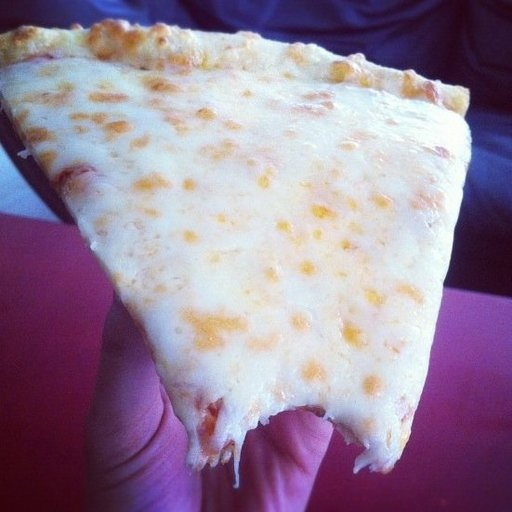

In [ ]:
import random
from PIL import Image

# set seed
# random.seed(42)

# get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) # regex of '/test/sushi/2948087.jpg'
# image_path_list
# pik a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# get the image class from the path name
image_class = random_image_path.parent.stem
print(image_class)

# open image
img = Image.open(random_image_path)

# print metadata
print(f"Random image path {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Text(0.5, 1.0, 'Image class: pizza  | Image shape: (512, 512, 3)')

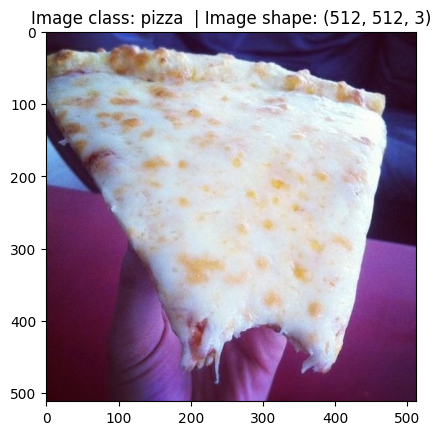

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# turn the image into an array
img_as_array = np.asarray(img)

# plot image with matplotlib
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class}  | Image shape: {img_as_array.shape}")

problem: all our images are in the form [heigh, width, color channels]. but pytorch only accepts tenor images in the form [color channels, height width].

solution? turn all outr images into pytorch tensors

# 3. Transforming data

We can turn our target data into tensors(tensor arrays)
we then turn it into a torch dataset and then into a torch dataloader
reminder that a torch dataset is a class containing a collection of data points ie our image
a dataloader wraps around the dataset, making the dataset iterable/loopable

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
data_transform = transforms.Compose([
    # resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # flip the images randomly to increase data augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    # turn the image to a torch tensor
    transforms.transforms.ToTensor()
])

In [ ]:
data_transform(img).shape

torch.Size([3, 64, 64])

## 3.1 visualizing our transformed image

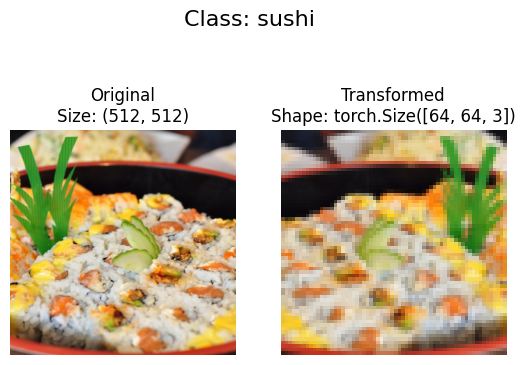

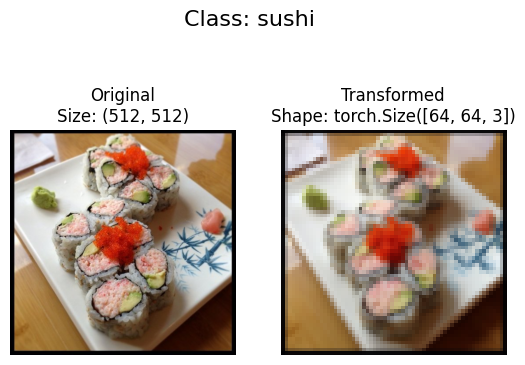

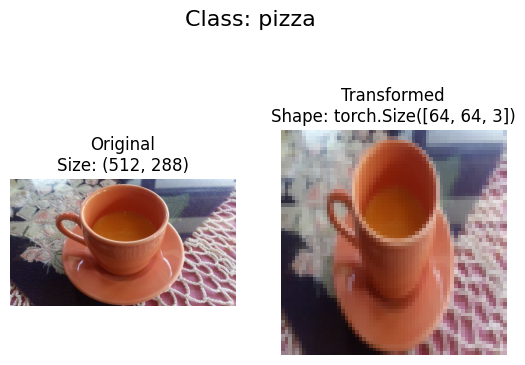

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """
    Plot a sample of original and transformed images side by side.

    Args:
    image_paths (list): List of paths to image files.
    transform (callable): PyTorch transform to be applied to the images.
    n (int, optional): Number of random images to plot. Defaults to 3.
    seed (int, optional): Random seed for reproducibility. Defaults to 42.

    Returns:
    None: This function plots the images but does not return any value.

    The function selects 'n' random images from the provided paths,
    applies the given transform to each, and plots the original and
    transformed versions side by side. It displays the original image size,
    the transformed image shape, and the image class (derived from the parent
    directory name of the image file).
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0)  # [color, height, width] becomes [height, width, color]
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, data_transform, n=3, seed=42)

# 4. Loading all our images using ImageFolder

In [ ]:
# Use ImageFolder to create datasets

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# get class names as a dict
train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
len(train_data), len(test_data)

(450, 150)

In [ ]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [ ]:
train_data[0]

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

In [ ]:
img, label = train_data[0]
img, class_names[label]

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

torch.Size([3, 64, 64])
torch.Size([64, 64, 3])


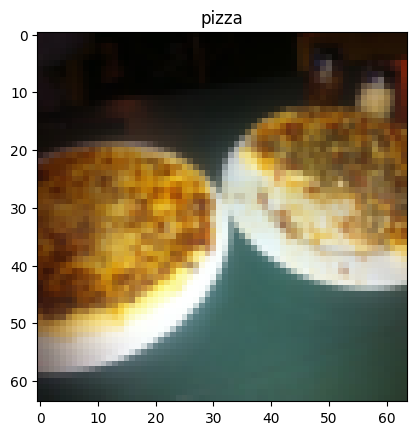

In [ ]:
img_permute = img.permute(1,2,0)

# print out different shapes
print(img.shape)
print(img_permute.shape)

# plot the image
plt.title(f"{class_names[label]}")
plt.imshow(img_permute)

## 4.1 Turn loaded images into dataloaders

In [ ]:
import os
os.cpu_count()

2

In [ ]:
# turn train and test datasets into dataloaders
from torch.utils.data import DataLoader
BATCH_SIZE=1                                # we will use 1 for now
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1, # we can set this to os.cpu_count to get the maximum cpu cores working
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=False)

train_dataloader, test_dataloader, len(train_dataloader), len(test_dataloader)

(<torch.utils.data.dataloader.DataLoader at 0x79cf25e47bb0>,
 450,
 150)

In [ ]:
# fetsch first image from train dataloader
img, label = next(iter(train_dataloader))
img.shape, label.shape, label

(torch.Size([1, 3, 64, 64]), torch.Size([1]), tensor([2]))

# 5. creating your own custom dataset ie replicating ImageFolder



In [ ]:
# steps:
# 1. load images from file
# 2. get class names from file
# 3. get classes as dictionary


# | Pros of creating a custom `Dataset` | Cons of creating a custom `Dataset` |
# | ----- | ----- |
# | Can create a `Dataset` out of almost anything. | Even though you *could* create a `Dataset` out of almost anything, it doesn't mean it will work. |
# | Not limited to PyTorch pre-built `Dataset` functions. | Using a custom `Dataset` often results in writing more code, which could be prone to errors or performance issues. |

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch .utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [ ]:
# instance  of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## 5.1 creating a helper function to get the class names


In [ ]:
# steps:
# 1. get the class names using os.scandir() to traverse a target directory
# 1. raise an error if the class names aren't found
# 1. turn the class names into a dict and a list and return them

In [ ]:
# setup path for target directory
target_directory = train_dir
target_directory

# get the class names from the direectory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found



['pizza', 'steak', 'sushi']

In [ ]:
{entry.name for entry in list(os.scandir(target_directory))}

{'pizza', 'steak', 'sushi'}

In [ ]:
# functionize class_names_found
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    # scan the target directory
    classes = sorted(entry.name for entry in list(os.scandir(target_directory)))
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}...Please check file structure")
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## 5.2 Create a custom dataset to replicate ImageFolder



**Steps to Create a Custom PyTorch Dataset**

1. Subclass `torch.utils.data.Dataset`
2. Initialize our subclass with a target directory
3. Create several attributes:
   - Paths of our images
   - Transform we would like to use
   - Target classes
   - `class_to_idx`: a dict of the target classes mapped to integer labels
4. Create a function to load images (i.e., open images)
5. Return the length of our dataset
6. Return a given sample when passed an index

This implementation results in a dataset similar to `torchvision.datasets.ImageFolder`:

```
Dataset ImageFolder
    Number of datapoints: 450
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
```

In [ ]:
# subclass Dataset
class ImageFolderCustom(Dataset):
    """Custom Dataset for loading images from a folder structure."""

    def __init__(self, target_dir: str, transform=None):
        """
        Initialize the dataset.

        Args:
            target_dir (str): Path to the target directory containing image folders.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        # create class attributes
        # Paths of our images
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
        # Transform we would like to use
        self.transform = transform
        # Target classes class_to_idx: a dict of the target classes mapped to integer labels
        self.classes, self.class_to_idx = find_classes(target_dir)
    # Create a function to load images (i.e., open images)
    def load_image(self, index: int) -> Image.Image:
        """
        Load an image given its index.
        """
        image_path = self.paths[index]
        return Image.open(image_path)

    # Return the length of our dataset
    def __len__(self) -> int:
        """
        Return the total number of samples in the dataset.

        """
        return len(self.paths)

    # Return a given sample when passed an index
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """
        Get a sample from the dataset.
        Returns img and label

        """
        img = self.load_image(index)
        class_name = self.paths[index].parent.name

        if self.transform:
            return self.transform(img), self.class_to_idx[class_name]
        else:
            return img, self.class_to_idx[class_name]

In [ ]:
# can i become cracked or am I just wasting my time.

In [ ]:
# test out our own custom data

# create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [ ]:
# test out ImageFolderCustom
train_data_custom = ImageFolderCustom(
    target_dir=train_dir,
    transform=train_transforms
)
test_data_custom = ImageFolderCustom(
    target_dir=test_dir,
    transform=test_transforms
)

In [ ]:
print("Train data custom:", train_data_custom)
print("Test data custom:", test_data_custom)
print("-" * 50)

print("Length of train_data:", len(train_data))
print("Length of train_data_custom:", len(train_data_custom))
print("-" * 50)

print("Length of test_data:", len(test_data))
print("Length of test_data_custom:", len(test_data_custom))
print("-" * 50)

print("Train data custom classes:", train_data_custom.classes)
print("Test data custom classes:", test_data_custom.classes)
print("-" * 50)

print("Train data custom class_to_idx:", train_data_custom.class_to_idx)
print("Test data custom class_to_idx:", test_data_custom.class_to_idx)
print("-" * 50)

print("Are train_data_custom classes equal to train_data classes?", train_data_custom.classes == train_data.classes)
print("Are test_data_custom classes equal to test_data classes?", test_data_custom.classes == test_data.classes)

Train data custom: <__main__.ImageFolderCustom object at 0x79cf25e67130>
Test data custom: <__main__.ImageFolderCustom object at 0x79cf25e67af0>
--------------------------------------------------
Length of train_data: 450
Length of train_data_custom: 450
--------------------------------------------------
Length of test_data: 150
Length of test_data_custom: 150
--------------------------------------------------
Train data custom classes: ['pizza', 'steak', 'sushi']
Test data custom classes: ['pizza', 'steak', 'sushi']
--------------------------------------------------
Train data custom class_to_idx: {'pizza': 0, 'steak': 1, 'sushi': 2}
Test data custom class_to_idx: {'pizza': 0, 'steak': 1, 'sushi': 2}
--------------------------------------------------
Are train_data_custom classes equal to train_data classes? True
Are test_data_custom classes equal to test_data classes? True


### 5.3 Visualizing our random images from the ImageFolderCustom datasets


Steps:
1. Take in a dataset and several other parameters, such as class names and the number of images to visualize.
2. Cap the number of images to be visualized at 10.
3. Set a random seed for reproducibility.
4. Get a list of random sample indexes from the target dataset.
5. Set up a matplotlib plot.
6. Loop through the randomly sampled images and plot them using matplotlib.
7. Ensure the dimensions of our images align with matplotlib's requirements.



In [ ]:
# Take in a dataset and several other parameters, such as class names and the number of images to visualize.
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int=None):
    # Cap the number of images to be visualized at 10.
    if n > 10:
        n = 10
        display_shape = False
        print(f"Display cant be greater than 10. Setting n to 10 and removing shape display")
    # Set a random seed for reproducibility.
    if seed:
        random.seed(seed)
    # Get a list of random sample indexes from the target dataset.
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    # Set up a matplotlib plot.
    plt.figure(figsize=(16, 8))

    # Loop through the randomly sampled images and plot them using matplotlib.
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # Ensure the dimensions of our images align with matplotlib's requirements.
        targ_image_adjust = targ_image.permute(1,2,0)

        # plot adjascent samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nShape: {targ_image_adjust.shape}"
        plt.title(title)




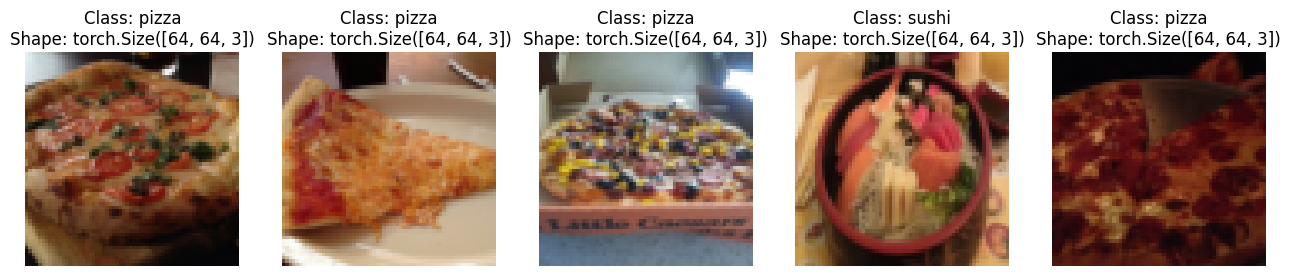

In [ ]:
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

## 5.4 Turn our Custom dataset into a dataloader


In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=False)


In [ ]:
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom, label_custom

(tensor([[[[0.3020, 0.3137, 0.3490,  ..., 0.5098, 0.4863, 0.4902],
           [0.5333, 0.5608, 0.5804,  ..., 0.4431, 0.4510, 0.4784],
           [0.5765, 0.5804, 0.5804,  ..., 0.5137, 0.5137, 0.4863],
           ...,
           [0.3255, 0.3294, 0.3412,  ..., 0.6706, 0.6784, 0.6980],
           [0.3294, 0.3333, 0.3451,  ..., 0.6549, 0.6431, 0.6706],
           [0.3333, 0.3373, 0.3333,  ..., 0.6471, 0.6431, 0.6706]],
 
          [[0.3373, 0.3725, 0.4235,  ..., 0.4784, 0.4510, 0.4510],
           [0.6784, 0.7176, 0.7451,  ..., 0.4039, 0.4000, 0.4314],
           [0.7529, 0.7647, 0.7529,  ..., 0.5216, 0.5176, 0.4588],
           ...,
           [0.2627, 0.2667, 0.2745,  ..., 0.7137, 0.7176, 0.7333],
           [0.2627, 0.2667, 0.2706,  ..., 0.6941, 0.6745, 0.7059],
           [0.2627, 0.2627, 0.2627,  ..., 0.6863, 0.6706, 0.6980]],
 
          [[0.2706, 0.3098, 0.3725,  ..., 0.1804, 0.1725, 0.1765],
           [0.6353, 0.6784, 0.6980,  ..., 0.1490, 0.1569, 0.1725],
           [0.7098, 0.72

# 6. Other forms of data augmentation

When you see data augmentation, think resizing, flipping, and padding. These simple image transformations create variations of existing data, helping models learn more robust features without collecting new images.
Blog Post:[How to Train State-Of-The-Art Models Using TorchVisions Latest Primitives](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/)

In [ ]:
# experimenting with transforms.TrivialAugmentWide
train_transform_trivialaug = transforms.Compose([
                                                transforms.Resize(size=(224, 224)),
                                                transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                                transforms.ToTensor()
])

test_transform_trvialaug = transforms.Compose([
                                                transforms.Resize(size=(224, 224)),
                                                transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                                transforms.ToTensor()
])

In [ ]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/sushi/865839.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2021381.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1168726.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1138695.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1422524.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1575445.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1232045.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/155981.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2692550.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1129338.jpg')]

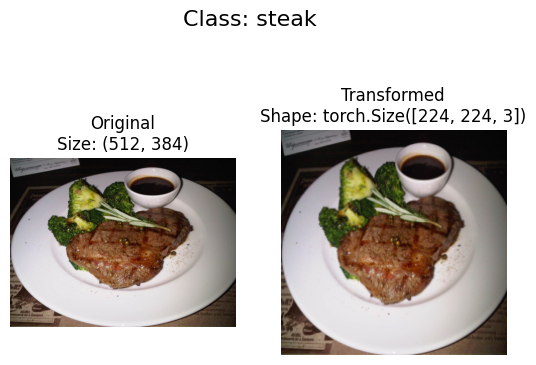

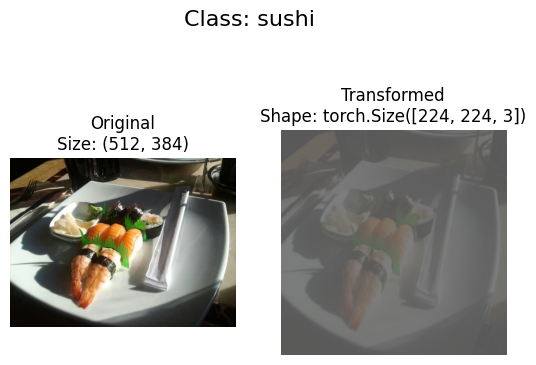

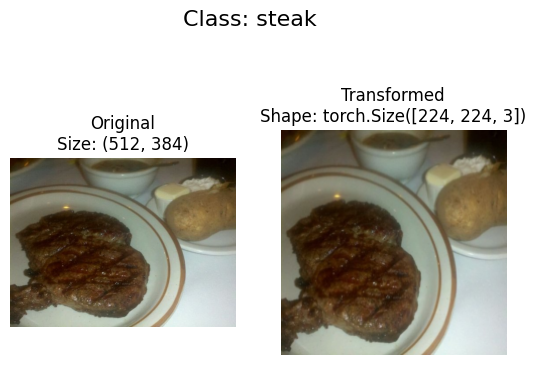

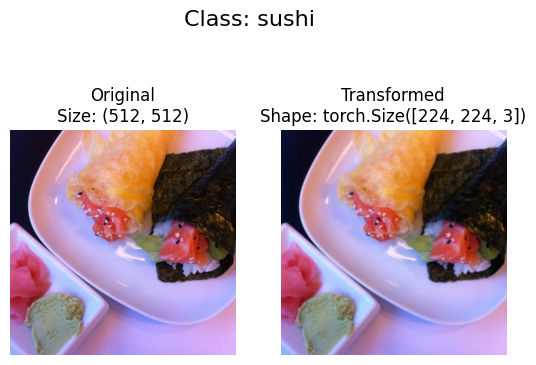

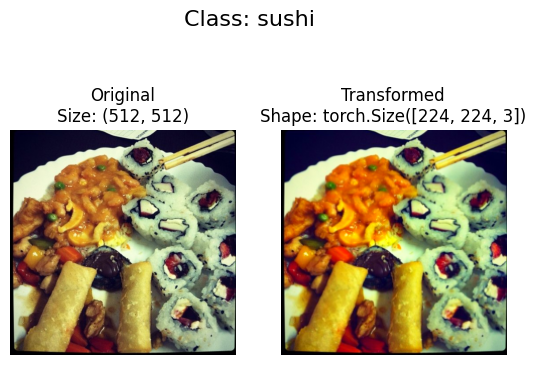

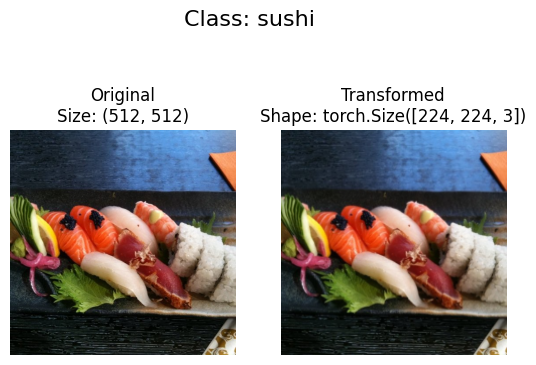

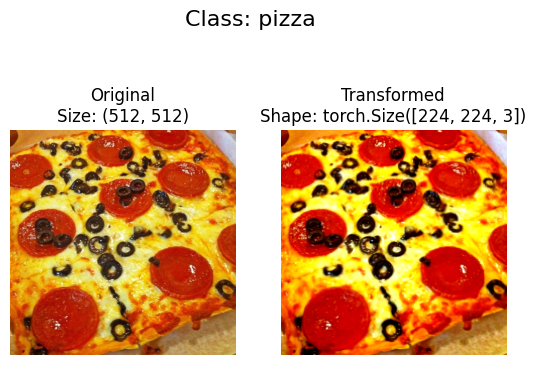

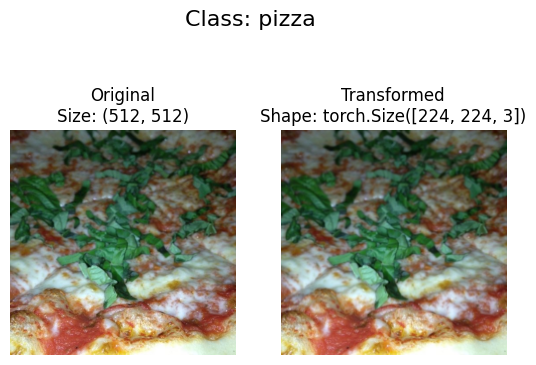

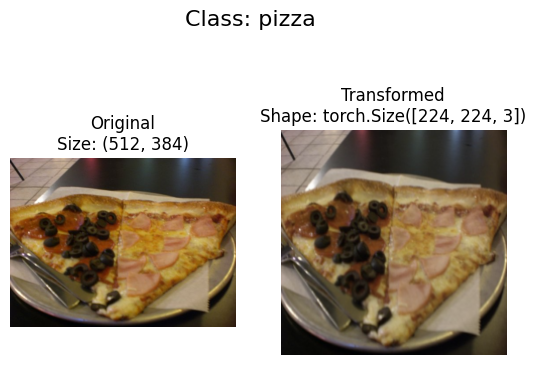

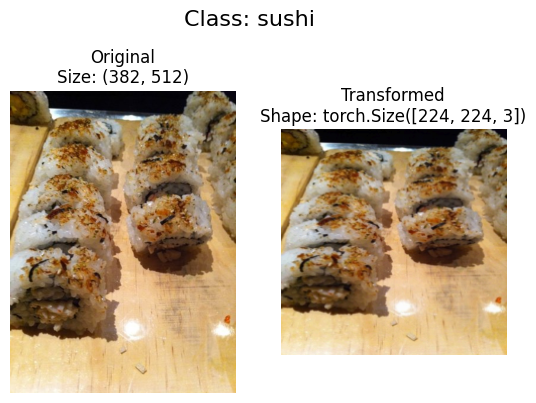

In [ ]:
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform_trivialaug,
                        n=10,
                        seed=None)

As you can see, trivialaugment applies image augmentations randomly on each image

# 7. Building our TinyVGG model without data augmentation

## 7.1 Transforms and loading data

In [ ]:
# simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])


In [ ]:
# load image data using ImageFolder
train_data_simple = datasets.ImageFolder(
                                        root=train_dir,
                                        transform=simple_transform
)
test_data_simple = datasets.ImageFolder(
                                        root=test_dir,
                                        transform=simple_transform
)
# create dataloaders
BATCH_SIZE=32
NUM_WORKERS  =os.cpu_count()
train_dataloaders_simple = DataLoader(
                                        dataset=train_data_simple,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS
)
test_dataloaders_simple = DataLoader(
                                        dataset=test_data_simple,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS
)

## 7.2 Create TinyVGG

In [ ]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int) -> None:
        """
        A simple VGG-style convolutional neural network.

        Args:
            input_shape (int): Number of input channels.
            output_shape (int): Number of output classes.
            hidden_units (int): Number of features in hidden layers.

        Attributes:
            conv_block_1 (nn.Sequential): First convolutional block.
            conv_block_2 (nn.Sequential): Second convolutional block.
            classifier (nn.Sequential): Classifier block with flattening and linear layer.
        """
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, 3, 1, 0 ),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 0 ),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 0),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*13*13, output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)
).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
dummy_image = torch.rand([32, 3, 64, 64]).to(device)
model_0(dummy_image)

tensor([[ 0.0219,  0.0011,  0.0110],
        [ 0.0229, -0.0016,  0.0063],
        [ 0.0214, -0.0012,  0.0055],
        [ 0.0206, -0.0008,  0.0082],
        [ 0.0208, -0.0017,  0.0105],
        [ 0.0211, -0.0035,  0.0107],
        [ 0.0210, -0.0014,  0.0082],
        [ 0.0199, -0.0025,  0.0083],
        [ 0.0207, -0.0019,  0.0084],
        [ 0.0218, -0.0022,  0.0097],
        [ 0.0219, -0.0017,  0.0085],
        [ 0.0194, -0.0021,  0.0077],
        [ 0.0227, -0.0031,  0.0096],
        [ 0.0217, -0.0031,  0.0074],
        [ 0.0219, -0.0013,  0.0063],
        [ 0.0220, -0.0007,  0.0076],
        [ 0.0220, -0.0037,  0.0099],
        [ 0.0210, -0.0019,  0.0096],
        [ 0.0216, -0.0009,  0.0082],
        [ 0.0229, -0.0026,  0.0102],
        [ 0.0216,  0.0003,  0.0085],
        [ 0.0217, -0.0015,  0.0061],
        [ 0.0224, -0.0014,  0.0098],
        [ 0.0209, -0.0028,  0.0064],
        [ 0.0186, -0.0043,  0.0073],
        [ 0.0227, -0.0034,  0.0080],
        [ 0.0209, -0.0013,  0.0078],
 

## 7.3 Using torchinfo to get an idea of the shapes in our model

In [ ]:
# since torchinfo isnt in colab, we have to import it
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model=model_0, input_size=[32,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

## 7.4 Replicatig train step and test step

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    # put the model in train mode
    model.train()

    # setup train loss and accuracy
    train_loss = 0
    train_acc = 0

    # loop through the batches
    for batch, (X, y) in enumerate(dataloader):
        # send data to target device
        X, y = X.to(device), y.to(device)
        # do the forward pass
        y_pred = model(X)
        # claculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        # optimizer zero grad
        optimizer.zero_grad()
        # loss backward
        loss.backward()
        # optimizer step step
        optimizer.step()

        # train accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    # average loss and accuracy
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device=device):
    # put the model in eval mode
    model.eval()

    # setup train loss and accuracy
    test_loss, test_acc = 0, 0

    # loop through the batches
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # send data to target device
            X, y = X.to(device), y.to(device)
            # do the forward pass
            y_test_pred = model(X)
            # claculate the loss
            loss = loss_fn(y_test_pred, y)
            test_loss += loss.item()
            # train accuracy
            y_pred_class = y_test_pred.argmax(dim=1)
            test_acc += (y_pred_class==y).sum().item()/len(y_test_pred)

    # average loss and accuracy
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## 7.6 Create a train function to combine train and test steps

In [ ]:
from tqdm.auto import tqdm

# create a train function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
    """
    Train a PyTorch model and evaluate it on test data.

    Args:
        model (torch.nn.Module): The neural network model to train.
        train_dataloader (torch.utils.data.DataLoader): DataLoader for training data.
        test_dataloader (torch.utils.data.DataLoader): DataLoader for test data.
        optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.
        loss_fn (torch.nn.Module, optional): Loss function. Defaults to nn.CrossEntropyLoss().
        epochs (int, optional): Number of training epochs. Defaults to 5.
        device (torch.device, optional): Device to run the model on. Defaults to the global 'device'.

    Returns:
        dict: A dictionary containing lists of training and test losses and accuracies for each epoch.
    """

    # create empty results dictt
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    # loop through epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloaders_simple,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloaders_simple,
                                        loss_fn=loss_fn,
                                        device=device)

        # print out whats happenin
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        # update results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    # return filled results
    return results


## 7.7 Train and evaluate model 0

In [ ]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
NUM_EPOCHS = 10

# recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  output_shape=len(train_data.classes),
                  hidden_units=10).to(device)

#   setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# start the timer
from timeit import default_timer as timer
start_time = timer()

# train the model
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloaders_simple,
                        test_dataloader=test_dataloaders_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_timer = timer()
print(f"Total training time: {end_timer-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1047 | Train acc: 0.3146 | Test loss: 1.0959 | Test acc: 0.3074
Epoch: 1 | Train loss: 1.0876 | Train acc: 0.3396 | Test loss: 1.0752 | Test acc: 0.4653
Epoch: 2 | Train loss: 1.0600 | Train acc: 0.4667 | Test loss: 1.0453 | Test acc: 0.4142
Epoch: 3 | Train loss: 1.0224 | Train acc: 0.4813 | Test loss: 0.9757 | Test acc: 0.5040
Epoch: 4 | Train loss: 0.9118 | Train acc: 0.5687 | Test loss: 0.9235 | Test acc: 0.5585
Epoch: 5 | Train loss: 0.9045 | Train acc: 0.5604 | Test loss: 0.9927 | Test acc: 0.4313
Epoch: 6 | Train loss: 0.8716 | Train acc: 0.6125 | Test loss: 0.9138 | Test acc: 0.5773
Epoch: 7 | Train loss: 0.8483 | Train acc: 0.6229 | Test loss: 0.9378 | Test acc: 0.5278
Epoch: 8 | Train loss: 0.8238 | Train acc: 0.5917 | Test loss: 0.9564 | Test acc: 0.5682
Epoch: 9 | Train loss: 0.9034 | Train acc: 0.5917 | Test loss: 0.9214 | Test acc: 0.5557
Total training time: 30.773 seconds


## 7.8 plot the loss curvers of model 0


In [ ]:
model_0_results

{'train_loss': [1.1046658356984456,
  1.0876118977864584,
  1.0600111881891887,
  1.0224268317222596,
  0.9117573499679565,
  0.9044861276944478,
  0.8715526183446248,
  0.8482598741849263,
  0.8237799723943074,
  0.9034433722496032],
 'train_acc': [0.3145833333333333,
  0.33958333333333335,
  0.4666666666666667,
  0.48125,
  0.56875,
  0.5604166666666667,
  0.6125,
  0.6229166666666667,
  0.5916666666666667,
  0.5916666666666667],
 'test_loss': [1.0958517074584961,
  1.0752140998840332,
  1.0453283190727234,
  0.9757222771644593,
  0.9235237240791321,
  0.9927149772644043,
  0.9137568473815918,
  0.9378056287765503,
  0.9564444065093994,
  0.9213920116424561],
 'test_acc': [0.3073863636363636,
  0.4653409090909091,
  0.41420454545454544,
  0.5039772727272728,
  0.5585227272727272,
  0.43125,
  0.5772727272727273,
  0.5278409090909091,
  0.5681818181818181,
  0.5556818181818182]}

In [ ]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
# make a function that accepts a dict with a lisst of floats
def plot_loss_curves(results: Dict[str, List[float]]):
    # get the loss values
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # get accuracy values
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # get number of epochs
    epochs = range(len(results["train_loss"]))

    # plot the loss
    plt.figure(figsize=(15, 7))

    # plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("loss")
    plt.xlabel("Epochs")
    plt.legend()

    # plot accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

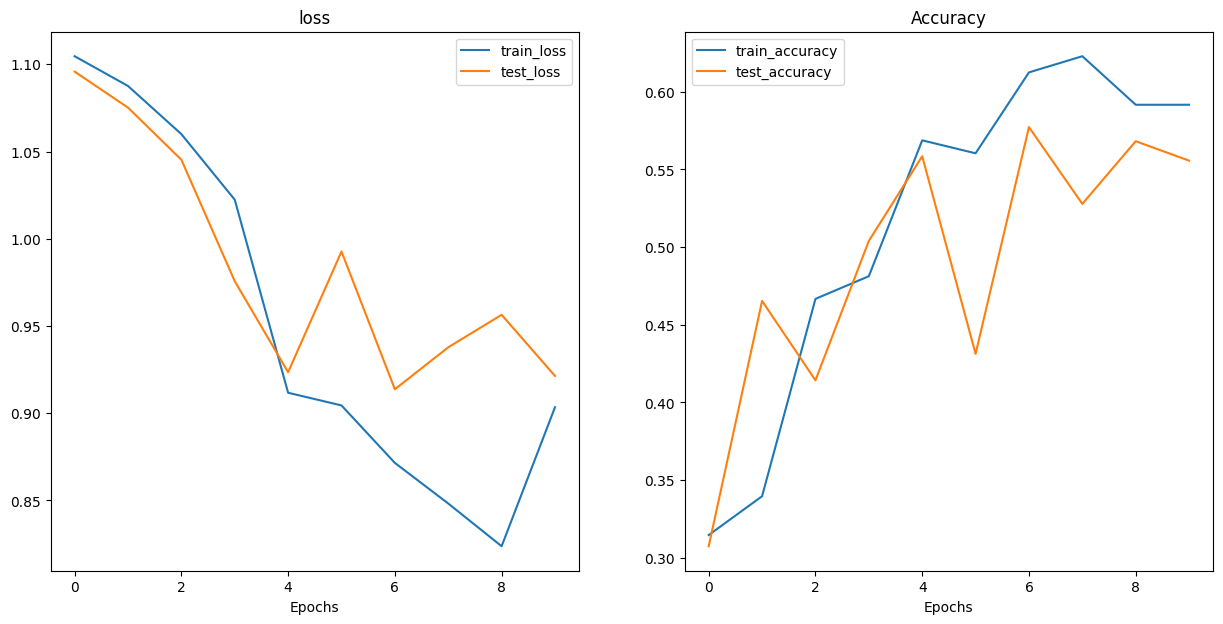

In [ ]:
plot_loss_curves(model_0_results)

# 8. What should an ideal loss curve look like?



Looking at training and test loss curves is a great way to see if your model is **overfitting**.

An overfitting model is one that performs better (often by a considerable margin) on the training set than the validation/test set.

If your training loss is far lower than your test loss, your model is **overfitting**.

As in, it's learning the patterns in the training too well and those patterns aren't generalizing to the test data.

The other side is when your training and test loss are not as low as you'd like, this is considered **underfitting**.

The ideal position for a training and test loss curve is for them to line up closely with each other.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg" alt="different training and test loss curves illustrating overfitting, underfitting and the ideal loss curves" width="800"/>

*Left: If your training and test loss curves aren't as low as you'd like, this is considered **underfitting**. *Middle:* When your test/validation loss is higher than your training loss this is considered **overfitting**. *Right:* The ideal scenario is when your training and test loss curves line up over time. This means your model is generalizing well. There are more combinations and different things loss curves can do, for more on these, see Google's [Interpreting Loss Curves guide](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic).*

### 8.1 How to deal with overfitting

Since the main problem with overfitting is that you're model is fitting the training data *too well*, you'll want to use techniques to "reign it in".

A common technique of preventing overfitting is known as [**regularization**](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html).

I like to think of this as "making our models more regular", as in, capable of fitting *more* kinds of data.

Let's discuss a few methods to prevent overfitting.

| **Method to prevent overfitting** | **What is it?** |
| ----- | ----- |
| **Get more data** | Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples. |
| **Simplify your model** | If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer. |
| **Use data augmentation** | [**Data augmentation**](https://developers.google.com/machine-learning/glossary#data-augmentation) manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data. |
| **Use transfer learning** | [**Transfer learning**](https://developers.google.com/machine-learning/glossary#transfer-learning) involves leveraging the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images. |
| **Use dropout layers** | Dropout layers randomly remove connections between hidden layers in neural networks, effectively simplifying a model but also making the remaining connections better. See [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) for more. |
| **Use learning rate decay** | The idea here is to slowly decrease the learning rate as a model trains. This is akin to reaching for a coin at the back of a couch. The closer you get, the smaller your steps. The same with the learning rate, the closer you get to [**convergence**](https://developers.google.com/machine-learning/glossary#convergence), the smaller you'll want your weight updates to be.  |
| **Use early stopping** | [**Early stopping**](https://developers.google.com/machine-learning/glossary#early_stopping) stops model training *before* it begins to overfit. As in, say the model's loss has stopped decreasing for the past 10 epochs (this number is arbitrary), you may want to stop the model training here and go with the model weights that had the lowest loss (10 epochs prior). |

There are more methods for dealing with overfitting but these are some of the main ones.

As you start to build more and more deep models, you'll find because deep learnings are *so good* at learning patterns in data, dealing with overfitting is one of the primary problems of deep learning.

### 8.2 How to deal with underfitting

When a model is [**underfitting**](https://developers.google.com/machine-learning/glossary#underfitting) it is considered to have poor predictive power on the training and test sets.

In essence, an underfitting model will fail to reduce the loss values to a desired level.

Right now, looking at our current loss curves, I'd considered our `TinyVGG` model, `model_0`, to be underfitting the data.

The main idea behind dealing with underfitting is to *increase* your model's predictive power.

There are several ways to do this.

| **Method to prevent underfitting** | **What is it?** |
| ----- | ----- |
| **Add more layers/units to your model** | If your model is underfitting, it may not have enough capability to *learn* the required patterns/weights/representations of the data to be predictive. One way to add more predictive power to your model is to increase the number of hidden layers/units within those layers. |
| **Tweak the learning rate** | Perhaps your model's learning rate is too high to begin with. And it's trying to update its weights each epoch too much, in turn not learning anything. In this case, you might lower the learning rate and see what happens. |
| **Use transfer learning** | Transfer learning is capable of preventing overfitting and underfitting. It involves using the patterns from a previously working model and adjusting them to your own problem. |
| **Train for longer** | Sometimes a model just needs more time to learn representations of data. If you find in your smaller experiments your model isn't learning anything, perhaps leaving it train for a more epochs may result in better performance. |
| **Use less regularization** | Perhaps your model is underfitting because you're trying to prevent overfitting too much. Holding back on regularization techniques can help your model fit the data better. |

### 8.3 The balance between overfitting and underfitting

None of the methods discussed above are silver bullets, meaning, they don't always work.

And preventing overfitting and underfitting is possibly the most active area of machine learning research.

Since everone wants their models to fit better (less underfitting) but not so good they don't generalize well and perform in the real world (less overfitting).

There's a fine line between overfitting and underfitting.

Because too much of each can cause the other.

Transfer learning is perhaps one of the most powerful techniques when it comes to dealing with both overfitting and underfitting on your own problems.

Rather than handcraft different overfitting and underfitting techniques, transfer learning enables you to take an already working model in a similar problem space to yours (say one from [paperswithcode.com/sota](https://paperswithcode.com/sota) or [Hugging Face models](https://huggingface.co/models)) and apply it to your own dataset.

We'll see the power of transfer learning in a later notebook.

# 9. Model 1: TinyVGG with Data Augmentation

Time to try out another model!

This time, let's load in the data and use **data augmentation** to see if it improves our results in anyway.

First, we'll compose a training transform to include `transforms.TrivialAugmentWide()` as well as resize and turn our images into tensors.

We'll do the same for a testing transform except without the data augmentation.



## 9.1 Create transform with data augmentation

In [ ]:
# create trivial augment transforms
train_transform_tivial = transforms.Compose([transforms.Resize(size=(64,64)),
                                             transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                             transforms.ToTensor()
])
test_transform_trivial = transforms.Compose([transforms.Resize(size=(64,64)),
                                             transforms.ToTensor()
])

## 9.2 Create train and test datasets and dataloaders with data augmentation

In [ ]:
# turn image folders into datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                               transform=train_transform_tivial,
                                               target_transform=None
                                               )
test_data_augmented = datasets.ImageFolder(root=test_dir,
                                              transform=test_transform_trivial)

# turn datasets into daaloaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_dataloader_augmented = DataLoader(dataset=test_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_WORKERS)

## 9.3 Create tinyVGG model

In [ ]:
# create model_1
model_1 = TinyVGG(input_shape=3,
                  output_shape=len(class_names),
                  hidden_units=10).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
# create a lossfn and an optimizer for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set no of epochs
NUM_EPOCHS  = 10

# setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# start the timer
from timeit import default_timer as timer
start_time = timer()

# train_model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_augmented,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1016 | Train acc: 0.3104 | Test loss: 1.0983 | Test acc: 0.3074
Epoch: 1 | Train loss: 1.0774 | Train acc: 0.4313 | Test loss: 1.0592 | Test acc: 0.4273
Epoch: 2 | Train loss: 1.0403 | Train acc: 0.4375 | Test loss: 0.9931 | Test acc: 0.5750
Epoch: 3 | Train loss: 0.9472 | Train acc: 0.5604 | Test loss: 0.9491 | Test acc: 0.4841
Epoch: 4 | Train loss: 0.8969 | Train acc: 0.5708 | Test loss: 0.9639 | Test acc: 0.4813
Epoch: 5 | Train loss: 0.9234 | Train acc: 0.5250 | Test loss: 0.9348 | Test acc: 0.4972
Epoch: 6 | Train loss: 0.9134 | Train acc: 0.5312 | Test loss: 0.9054 | Test acc: 0.5705
Epoch: 7 | Train loss: 0.9046 | Train acc: 0.5667 | Test loss: 0.9153 | Test acc: 0.5097
Epoch: 8 | Train loss: 0.9062 | Train acc: 0.5792 | Test loss: 0.8883 | Test acc: 0.6057
Epoch: 9 | Train loss: 0.9084 | Train acc: 0.5229 | Test loss: 0.8929 | Test acc: 0.5972
Total training time: 30.846 seconds


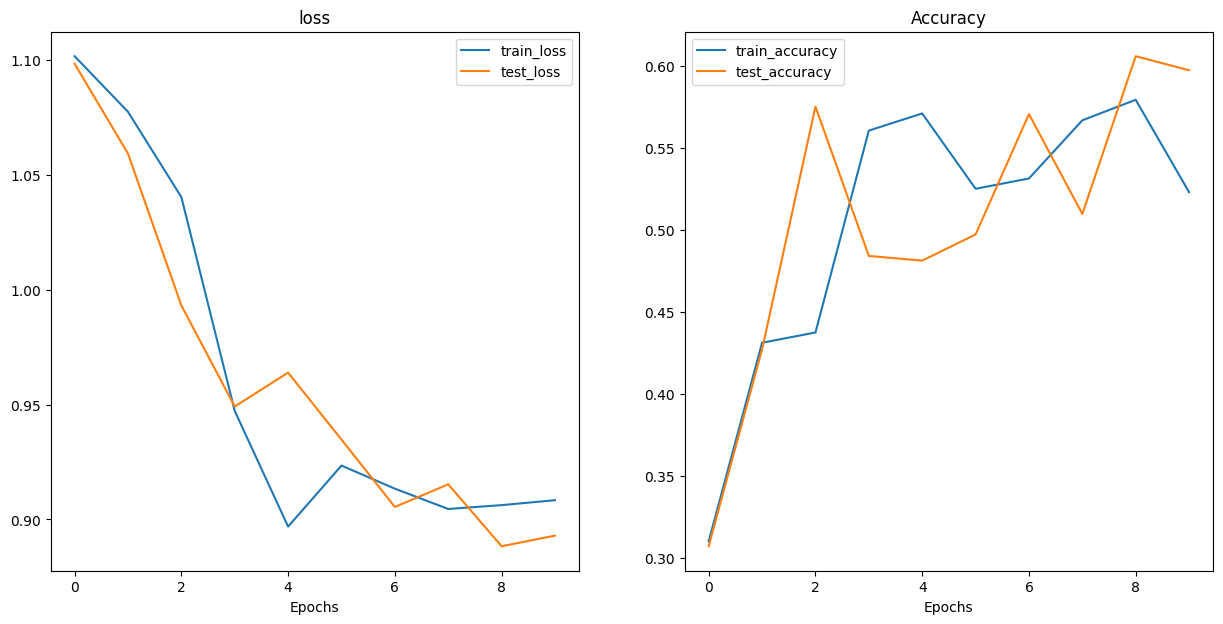

In [ ]:
plot_loss_curves(model_1_results)

We are back!

# 10. Comparing model results

Other sources:


1.   Hard coding
2.   Pytorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3.   Weights and biases - https://wandb.ai/site
4.   MLFlow - https://pytorch.org/docs/stable/tensorboard.html



Even though our models our performing quite poorly, we can still write code to compare them.

Let's first turn our model results in pandas DataFrames.

In [ ]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

model_0_df

train_loss  train_acc  test_loss  test_acc
0    1.104666   0.314583   1.095852  0.307386
1    1.087612   0.339583   1.075214  0.465341
2    1.060011   0.466667   1.045328  0.414205
3    1.022427   0.481250   0.975722  0.503977
4    0.911757   0.568750   0.923524  0.558523
5    0.904486   0.560417   0.992715  0.431250
6    0.871553   0.612500   0.913757  0.577273
7    0.848260   0.622917   0.937806  0.527841
8    0.823780   0.591667   0.956444  0.568182
9    0.903443   0.591667   0.921392  0.555682

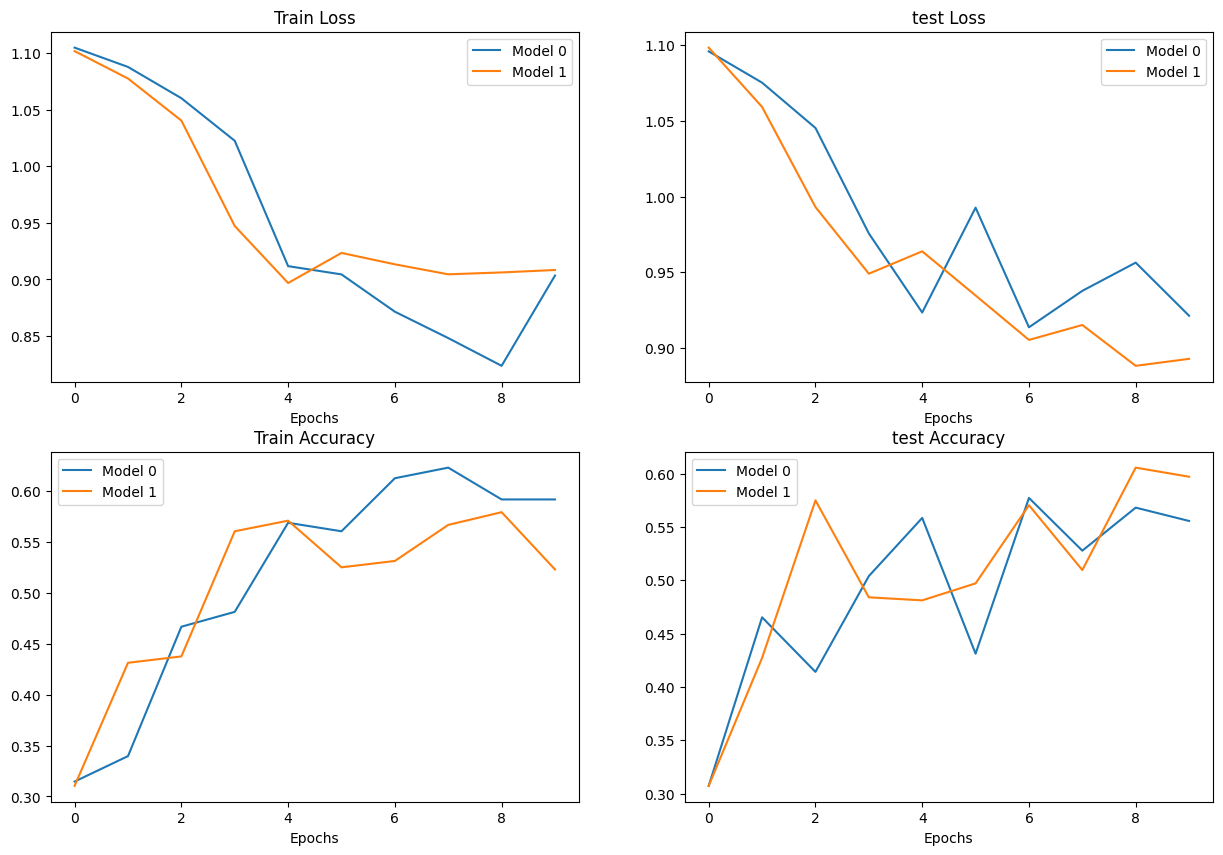

In [ ]:
# setup a plot
plt.figure(figsize=(15, 10))

# get number of epochs
epochs = range(len(model_0_df))

# plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend();

# plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("test Loss")
plt.xlabel("Epochs")
plt.legend();

# plot training accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend();


# plot testing accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("test Accuracy")
plt.xlabel("Epochs")
plt.legend();


# Making a prediction on a custom image

In [ ]:
# download custom image
import requests

# setup custom image
custom_image_path = data_path / "04-pizza-dad.jpeg"

# download the image if it doesn't exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # when downloading from github, we need the raw file
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)

else:
    print(f"File {custom_image_path} already exists. skipping download")

## 11.1loading our custom image into our model



- We use PyTorch's vision I/O library to read images.
- We can use the `read_image` function to load JPEG or PNG images as 3D Tensors.
- When we use custom images with our pre-trained model, we need to:
  1. Resize them to match our model's input size (e.g., 64x64).
  2. Convert them to float32 type.
  3. Move them to our model's device (CPU or GPU).
  4. Apply any normalization we used in training.
- By doing this, we ensure our custom images match our model's expected format.


In [ ]:
import torchvision

# read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
# Print shape and datatype
print(f"Shape of custom_image_uint8: {custom_image_uint8.shape}")
print(f"Datatype of custom_image_uint8: {custom_image_uint8.dtype}")

Shape of custom_image_uint8: torch.Size([3, 4032, 3024])
Datatype of custom_image_uint8: torch.uint8


Shape of custom_image_uint8: torch.Size([3, 4032, 3024])
Datatype of custom_image_uint8: torch.uint8


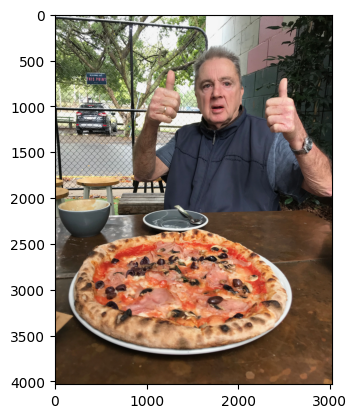

In [ ]:
plt.imshow(custom_image_uint8.permute(1,2,0))
print(f"Shape of custom_image_uint8: {custom_image_uint8.shape}")
print(f"Datatype of custom_image_uint8: {custom_image_uint8.dtype}")

## 11.2 Making a prediction on a custom image with a trained model

In [ ]:
# seeing errors when predicting on a wrong image type
model_1.eval()
try:
    with torch.inference_mode():
        output = model_1(custom_image_uint8.to(device))
    print("Inference successful")
except Exception as e:
    print(f"An error occurred during inference: {str(e)}")

An error occurred during inference: Input type (unsigned char) and bias type (float) should be the same


In [ ]:
# converting from 0,255 to 0,1
custom_image_uint8 = custom_image_uint8.type(torch.float32) / 255

model_1.eval()
try:
    with torch.inference_mode():
        output = model_1(custom_image_uint8.to(device))
    print("Inference successful")
except Exception as e:
    print(f"An error occurred during inference: {str(e)}")

An error occurred during inference: mat1 and mat2 shapes cannot be multiplied (10x756765 and 1690x3)


Shape of custom_image_uint8: torch.Size([3, 64, 64])
Datatype of custom_image_uint8: torch.float32


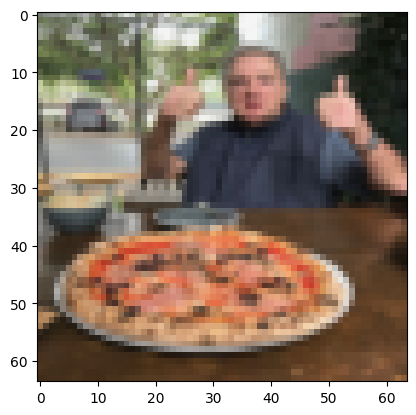

In [ ]:
# creating a transform pipeline to resize the image
custom_image_transform = transforms.Compose([transforms.Resize(size=(64, 64))])

custom_image_transformed = custom_image_transform(custom_image_uint8)
plt.imshow(custom_image_transformed.permute(1,2,0))
print(f"Shape of custom_image_uint8: {custom_image_transformed.shape}")
print(f"Datatype of custom_image_uint8: {custom_image_transformed.dtype}")

In [ ]:
# trying with resized image
model_1.eval()
try:
    with torch.inference_mode():
        output = model_1(custom_image_transformed.to(device))
    print("Inference successful")
except Exception as e:
    print(f"An error occurred during inference: {str(e)}")

An error occurred during inference: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)


In [ ]:
# adding an extra dimension
model_1.eval()
try:
    with torch.inference_mode():
        output = model_1(custom_image_transformed.unsqueeze(0).to(device))
    print("Inference successful")
except Exception as e:
    print(f"An error occurred during inference: {str(e)}")

Inference successful


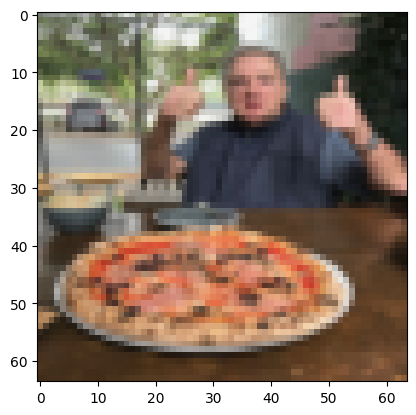

In [ ]:
# plot image
plt.imshow(custom_image_transformed.permute(1,2,0))

In [ ]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred, torch.softmax(custom_image_pred, dim=1), torch.argmax(torch.softmax(custom_image_pred, dim=1), dim=1),class_names[torch.argmax(torch.softmax(custom_image_pred, dim=1), dim=1)]

(tensor([[-0.1117,  0.0093, -0.1580]], device='cuda:0'),
 tensor([[0.3243, 0.3660, 0.3096]], device='cuda:0'),
 tensor([1], device='cuda:0'),
 'steak')

In [ ]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

# Get the raw prediction logits
pred_logits = custom_image_pred
print("Raw prediction logits:", pred_logits)

# Apply softmax to get probabilities
pred_probs = torch.softmax(pred_logits, dim=1)
print("Prediction probabilities:", pred_probs)

# Get the class with the highest probability
pred_class_idx = torch.argmax(pred_probs, dim=1)
print("Predicted class index:", pred_class_idx)

# Convert the class index to the actual class name
pred_class_name = class_names[pred_class_idx]
print("Predicted class name:", pred_class_name)


Raw prediction logits: tensor([[-0.1117,  0.0093, -0.1580]], device='cuda:0')
Prediction probabilities: tensor([[0.3243, 0.3660, 0.3096]], device='cuda:0')
Predicted class index: tensor([1], device='cuda:0')
Predicted class name: steak


## 11.3 Putting custom image prediction together: building a function



Doing all of the above steps every time you'd like to make a prediction on a custom image would quickly become tedious.

So let's put them all together in a function we can easily use over and over again.

Specifically, let's make a function that:
1. Takes in a target image path and converts to the right datatype for our model (`torch.float32`).
2. Makes sure the target image pixel values are in the range `[0, 1]`.
3. Transforms the target image if necessary.
4. Makes sure the model is on the target device.
5. Makes a prediction on the target image with a trained model (ensuring the image is the right size and on the same device as the model).
6. Converts the model's output logits to prediction probabilities.
7. Converts the prediction probabilities to prediction labels.
8. Plots the target image alongside the model prediction and prediction probability.

A fair few steps but we've got this!

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

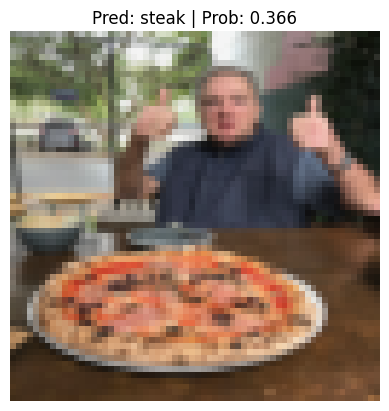

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

## Main takeaways

We've covered a fair bit in this module.

Let's summarise it with a few dot points.

* PyTorch has many in-built functions to deal with all kinds of data, from vision to text to audio to recommendation systems.
* If PyTorch's built-in data loading functions don't suit your requirements, you can write code to create your own custom datasets by subclassing `torch.utils.data.Dataset`.
* `torch.utils.data.DataLoader`'s in PyTorch help turn your `Dataset`'s into iterables that can be used when training and testing a model.
* A lot of machine learning is dealing with the balance between **overfitting** and **underfitting** (we discussed different methods for each above, so a good exercise would be to research more and writing code to try out the different techniques).
* Predicting on your own custom data with a trained model is possible, as long as you format the data into a similar format to what the model was trained on. Make sure you take care of the three big PyTorch and deep learning errors:
    1. **Wrong datatypes** - Your model expected `torch.float32` when your data is `torch.uint8`.
    2. **Wrong data shapes** - Your model expected `[batch_size, color_channels, height, width]` when your data is `[color_channels, height, width]`.
    3. **Wrong devices** - Your model is on the GPU but your data is on the CPU.